# ch20_1 openAI embedding API

이번 챕터에서는 LLM을 이용한 서비스 개발 시에 유용하게 사용할 embedding API에 대해서 배워보겠습니다. 이는 openAI가 공개한 API들 중 하나로, 방대한 텍스트에 대해서 미리 학습한 언어 모델로 텍스트에 대한 임베딩을 추출하여 리턴해주는 서비스입니다. 이를 이용해서 유저가 읽고 싶은 책을 추천하는 서비스를 개발해보고자 합니다. 구현할 서비스 아키텍처는 아래와 같습니다.

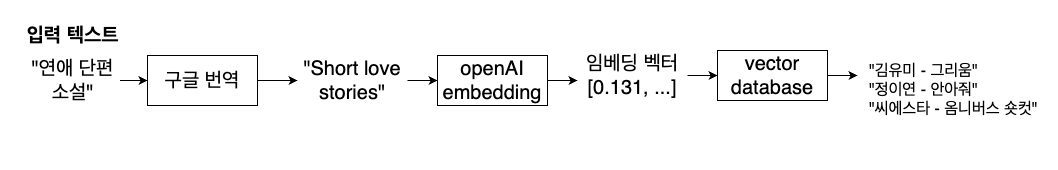

구현할 파이프라인은 다음과 같습니다.

1. 입력 텍스트를 영어로 번역
2. openAI embedding API로 임베딩 벡터 추출
3. vector database에 유사도 검색
4. 추천 결과 보여주기

이를 위해선 미리 책의 줄거리들의 임베딩 벡터를 추출하여 벡터 데이터베이스에 채워넣어야 합니다. 스텝 바이 스텝으로 구현해보겠습니다.

## 데이터 셋 준비

### 메타데이터 불러오기 
yes24에서 미리 수집한 데이터 셋을 불러오겠습니다. 먼저 책의 제목, 줄거리, 줄거리의 영문 번역을 담은 메타데이터를 불러오겠습니다.

In [167]:
import pandas as pd

metadata_df = pd.read_csv("./data/books_metadata.csv", index_col="id")

In [168]:
metadata_df.head()

,url,img_url,title,authors,publisher,published_at,review_cnt,rating,summary,translation
id,,,,,,,,,,
2,https://www.yes24.com/Product/Goods/2,https://image.yes24.com/goods/2/L,기억의 상처,노은,좋은날,1998-09,2.0,7.0,"성폭행 그리고 끝 내 자살이라는 방법으로 생을 마감할 수 밖에 없었던 주인공 문희,...",It depicts the tragic love of a woman through ...
4,https://www.yes24.com/Product/Goods/4,https://image.yes24.com/goods/4/L,큰 오빠 1,박정근,우리문학사(노영근),1998-11,0.0,0.0,물질적 풍요보다는 내 부모 형제들과 나눌 수 있는 가족애야말로 가장 근본적인 진정한...,Family love that I can share with my parents a...
14,https://www.yes24.com/Product/Goods/14,https://image.yes24.com/goods/14/L,피리새는 피리가 없다 2,김형경,한겨레신문사,1998-11,3.0,8.0,지극히 평범한 주부인 영숙의 언더그라운드 대중음악가수 시절을 회상하는 이야기. 열정...,"The story of Yeong-sook, an extremely ordinary..."
15,https://www.yes24.com/Product/Goods/15,https://image.yes24.com/goods/15/L,행복,함정임,중앙m&b,1998-10,1.0,8.0,"요절한 소설가 남편 김소진을 그리는 여류작가의 감성소설. 한 남자와의 애절한 사랑,...",An emotional novel by a female writer who port...
16,https://www.yes24.com/Product/Goods/16,https://image.yes24.com/goods/16/L,마지막 춤은 나와 함께,은희경,문학동네,1998-11,48.0,7.4,은희경의 소설 '마지막 춤은 나와 함께'는 사랑에 대한 관점을 새롭게 제시한다. 이...,Eun Hee-kyung's novel 'Last Dance with Me' pre...


### 임베딩 벡터 데이터 불러오기
그 다음, 미리 사전에 openAI embedding API로 추출한 임베딩을 불러오겠습니다. 이 임베딩 벡터는 영문으로 번역한 소설의 줄거리를 openAI embedding API로 추출한 것입니다. 한글이 아닌 영어를 사용한 이유는 embedding API의 경우, 영어 문장에서 확연히 뛰어난 성능을 보여주기 때문입니다.

In [169]:
embedding_df = pd.read_csv("./data/books_embeddings.csv", index_col="id")

In [170]:
embedding_df.head()

,embedding
id,
2,"[-0.019453685730695724, -0.026463313028216362,..."
4,"[0.028712131083011627, -0.018639089539647102, ..."
14,"[2.1535393898375332e-05, -0.036296259611845016..."
15,"[-0.014089467003941536, -0.030050499364733696,..."
16,"[-0.010307575576007366, -0.02389790490269661, ..."


문자열 형태의 임베딩을 list로 바꿔주겠습니다.

In [171]:
from tqdm import tqdm

tqdm.pandas()
embedding_df["embedding"] = embedding_df["embedding"].progress_apply(lambda x: eval(x))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18718/18718 [00:43<00:00, 430.38it/s]


### 임베딩 벡터 차원 확인

한번 임베딩 벡터의 차원을 확인해보면 1536 차원임을 알 수 있습니다.

In [172]:
len(embedding_df.iloc[0]["embedding"])

1536

### 메타 데이터와 임베딩 조인

이제 메타데이터와 임베딩 벡터를 조인해주고, 결측치를 확인하겠습니다.

In [173]:
df = metadata_df.join(embedding_df)

In [174]:
df.head()

,url,img_url,title,authors,publisher,published_at,review_cnt,rating,summary,translation,embedding
id,,,,,,,,,,,
2,https://www.yes24.com/Product/Goods/2,https://image.yes24.com/goods/2/L,기억의 상처,노은,좋은날,1998-09,2.0,7.0,"성폭행 그리고 끝 내 자살이라는 방법으로 생을 마감할 수 밖에 없었던 주인공 문희,...",It depicts the tragic love of a woman through ...,"[-0.019453685730695724, -0.026463313028216362,..."
4,https://www.yes24.com/Product/Goods/4,https://image.yes24.com/goods/4/L,큰 오빠 1,박정근,우리문학사(노영근),1998-11,0.0,0.0,물질적 풍요보다는 내 부모 형제들과 나눌 수 있는 가족애야말로 가장 근본적인 진정한...,Family love that I can share with my parents a...,"[0.028712131083011627, -0.018639089539647102, ..."
14,https://www.yes24.com/Product/Goods/14,https://image.yes24.com/goods/14/L,피리새는 피리가 없다 2,김형경,한겨레신문사,1998-11,3.0,8.0,지극히 평범한 주부인 영숙의 언더그라운드 대중음악가수 시절을 회상하는 이야기. 열정...,"The story of Yeong-sook, an extremely ordinary...","[2.1535393898375332e-05, -0.036296259611845016..."
15,https://www.yes24.com/Product/Goods/15,https://image.yes24.com/goods/15/L,행복,함정임,중앙m&b,1998-10,1.0,8.0,"요절한 소설가 남편 김소진을 그리는 여류작가의 감성소설. 한 남자와의 애절한 사랑,...",An emotional novel by a female writer who port...,"[-0.014089467003941536, -0.030050499364733696,..."
16,https://www.yes24.com/Product/Goods/16,https://image.yes24.com/goods/16/L,마지막 춤은 나와 함께,은희경,문학동네,1998-11,48.0,7.4,은희경의 소설 '마지막 춤은 나와 함께'는 사랑에 대한 관점을 새롭게 제시한다. 이...,Eun Hee-kyung's novel 'Last Dance with Me' pre...,"[-0.010307575576007366, -0.02389790490269661, ..."


In [175]:
df.isnull().sum()

url             0
img_url         0
title           0
authors         0
publisher       0
published_at    0
review_cnt      0
rating          0
summary         0
translation     0
embedding       0
dtype: int64

## 벡터 데이터베이스에 임베딩 벡터 저장

### pinecone index 설정

pinecone 콘솔로 이동하여 이미지 검색에 사용했던 인덱스는 삭제하고, 텍스트 임베딩을 저장할 인덱스를 생성해줍니다. 이 때, 차원을 반드시 1536으로 맞춰주셔야 합니다.

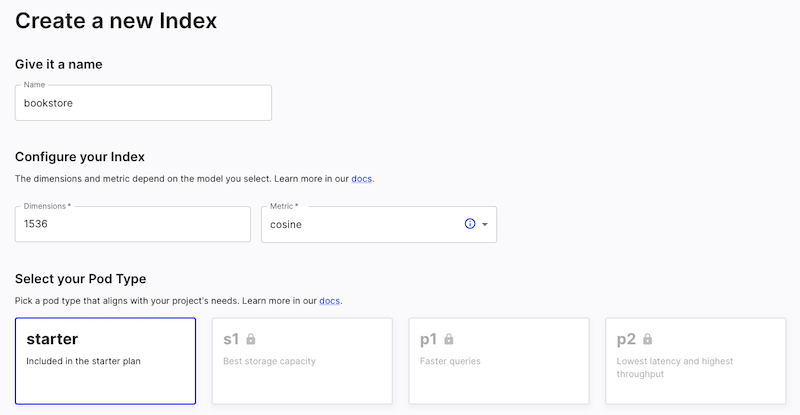

### pinecone 인덱스 접속 설정

pinecone console에서 인덱스 접속 정보를 확인하겠습니다.

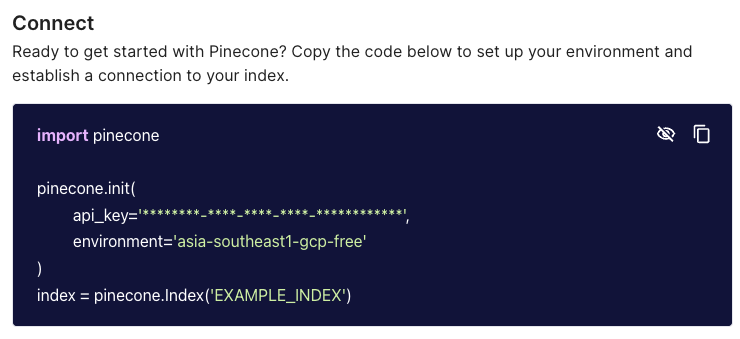

접속 정보를 입력하고 pinecone index 객체를 생성하겠습니다.

In [ ]:
from getpass import getpass

pinecone_region = "asia-southeast1-gcp-free"
pinecone_key = getpass("PINECONE API KEY")

In [ ]:
import pinecone

pinecone.init(
    api_key=pinecone_key,
    environment=pinecone_region
)

In [ ]:
index = pinecone.Index("bookstore")

In [ ]:
index.describe_index_stats()

### 벡터 저장

이제 임베딩 벡터와 메타데이터를 묶어서 벡터 데이터 베이스에 저장하겠습니다. 코드는 이미지 검색 구현 시에 사용했던 코드와 동일합니다.

In [ ]:
batch_size = 100

for i in tqdm(range(0, len(df), batch_size)):
    batch_df = df[i:i+batch_size]
    vectors = []
    for j in range(len(batch_df)):
        row = batch_df.iloc[j]
        id_ = row.name
        embedding = row["embedding"]
        metadata = row.drop(["embedding", "translation"]).to_dict()
        vectors.append((str(id_), embedding, metadata))
    response = index.upsert(vectors)

벡터들이 잘 저장되었는지 확인해보겠습니다.

In [ ]:
index.describe_index_stats()

In [ ]:
index.fetch(ids=["2"])

## 추천 파이프라인 구축

이제 책 줄거리 임베딩 벡터로 디비를 채워놓았으니 추천 파이프라인을 구축해보겠습니다. 

1. 입력 텍스트를 영어로 번역하기
2. openAI embedding API로 임베딩 추출하기
3. vector database를 이용해서 추천 받기

### 구글 번역 사용

GCP console에서 cloud translation API 사용 설정해줍니다.

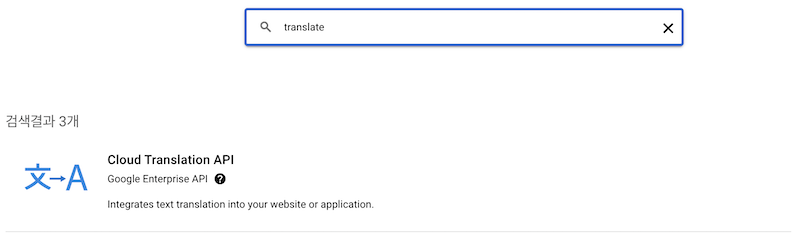

그 다음, IAM 및 관리자 탭에서 서비스 계정을 선택하시고, cloud translation API 관리자 권한을 가진cccccccloud translation AP

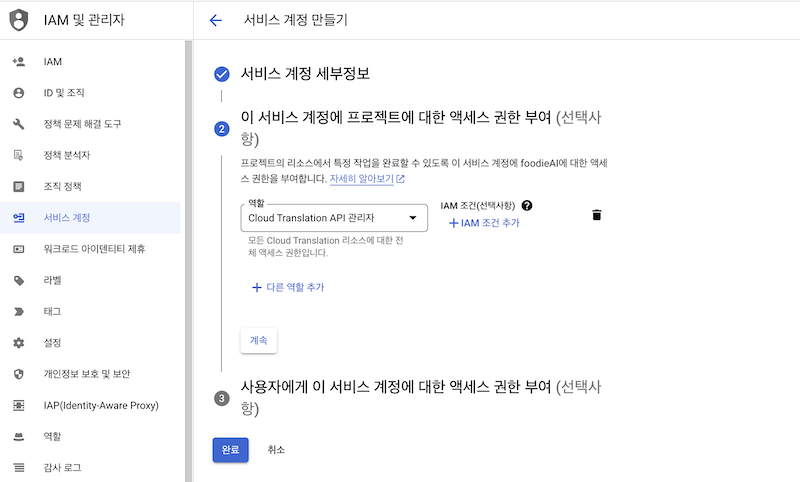

새롭게 만든 서비스 계정에 JSON 타입의 새 키를 만들어 줍니다.

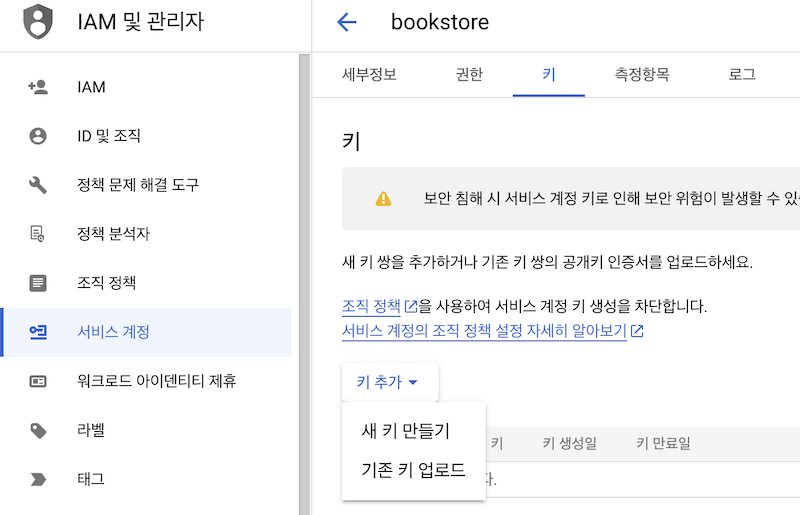

다운받은 키 값은 data 폴더 안에 넣어줍니다. 이제 인증키 값을 가지고 google translation client를 생성해보겠습니다.

In [ ]:
!pip install google-auth
!pip install google-cloud-translate

In [ ]:
import json

with open("./data/google_secret.json") as fr:
    google_secret = json.loads(fr.read())

In [ ]:
from google.oauth2.service_account import Credentials
from google.cloud import translate

credentials = Credentials.from_service_account_info(google_secret)
google_translate_client = translate.TranslationServiceClient(credentials=credentials)

In [ ]:
def get_translation(query):
    parent = f"projects/{google_secret['project_id']}/locations/global"
    response = google_translate_client.translate_text(
        request={
            "parent": parent,
            "contents": [query],
            "mime_type": "text/plain",
            "source_language_code": "ko",
            "target_language_code": "en-US",
        }
    )
    return response.translations[0].translated_text

In [ ]:
query = "가슴이 따뜻해지는 여행기"
eng_query = get_translation(query)
print(eng_query)

### openAI embedding API 사용

이제 openAI의 embedding API를 사용해보겠습니다.

In [ ]:
import openai
import os

In [ ]:
openai.api_key = os.environ.get("OPENAI_TOKEN")

In [ ]:
def get_embedding(query):
    response = openai.Embedding.create(
        input=[query], 
        model="text-embedding-ada-002"
    )
    return response["data"][0]["embedding"]

In [ ]:
embedding = get_embedding(eng_query)

In [ ]:
print(len(embedding))

### 벡터 데이터 베이스에 유사도 검색하기

이제 pinecone에 쿼리를 날려서 책 추천 결과를 가져와 보겠습니다.

In [ ]:
def vector_search(query_embedding):
    results = index.query(
        vector=query_embedding,
        top_k=3,
        include_metadata=True,
    )
    matches = results["matches"]
    return [x["metadata"] for x in matches]

In [ ]:
vector_search(embedding)

### 파이프라인 구축

이 과정을 하나로 엮어서 파이프라인으로 만들어보겠습니다.

In [ ]:
def recommend(query):
    eng_query = get_translation(query)
    embedding = get_embedding(eng_query)
    results = vector_search(embedding)
    return results

In [ ]:
query = "슈퍼 개발자가 되는 소년의 이야기"
items = recommend(query)

## 추천 결과를 이용해서 추천사 작성

openAI chat completion API를 이용해서 추천 결과를 가지고 추천사를 작성해보겠습니다. 이 때, AI에게 책방지기라는 역할을 부여하면 더 그럴듯한 텍스트를 생성해줍니다.

In [ ]:
def generate_prompt(query, items):
    prompt = f"""
유저가 읽고 싶은 책에 대한 묘사와 이에 대한 추천 결과가 주어집니다.
유저의 입력과 각 추천 결과 책의 제목, 저자, 소개 등을 참고하여 추천사를 작성하세요.
당신에 대한 소개를 먼저 하고, 친절한 말투로 작성해주세요.
중간 중간 이모지를 적절히 사용해주세요.

---
유저 입력: {query}

추천 결과 1
제목: {items[0]['title']}
저자: {items[0]['authors']}
책소개: {items[0]['summary']}

추천 결과 2
제목: {items[1]['title']}
저자: {items[1]['authors']}
책소개: {items[1]['summary']}

추천 결과 3
제목: {items[2]['title']}
저자: {items[2]['authors']}
책소개: {items[2]['summary']}
---
"""
    return prompt

In [ ]:
prompt = generate_prompt(query, items)

In [ ]:
print(prompt)

In [ ]:
def request_chat_completion(prompt):
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "당신은 책을 추천해주는 책방지기, 웜즈입니다."},
            {"role": "user", "content": prompt}
        ]
    )
    return response["choices"][0]["message"]["content"]

In [ ]:
generated_text = request_chat_completion(prompt)

In [ ]:
print(generated_text)

전체 텍스트를 생성하는데 시간이 많이 소요됩니다만, 이는 서비스 개발 시에 streaming response를 사용하여 개선할 수 있습니다. 다음 챕터에 process_generated_text 함수를 참고해주세요.

## 정리

이번 챕터에서는 openAI embedding API를 이용하여 책을 추천해주는 기능을 구현해보았습니다. 임베딩을 추출하는 대상이 텍스트일 뿐이지, 전반적인 구조는 신발 이미지 검색과 동일하였습니다. openAI embedding API는 무척 저렴하면서도 동시에 성능이 뛰어나서 활용도가 높으니, 사용법을 잘 숙지했다가 요긴하게 써먹으시길 바랍니다.